In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import json
from pprint import pprint
import re

# Define some utils

In [21]:
def is_conservative(s):
    # Define the pattern for "(union|intersection|setminus) X.[RL] X.[RL]"
    pattern_main = r'(union|intersection|setminus) (X\.R X\.L|X\.L X\.R)'
    
    # Find all occurrences of this pattern
    main_matches = re.findall(pattern_main, s)
    
    # Remove the matched main pattern from the string to check for the presence of X.R or X.L exclusively
    s_without_main = re.sub(pattern_main, '', s)
    
    # Check for exclusive presence of X.R or X.L in the rest of the string
    x_r_matches = re.findall(r'X\.R', s_without_main)
    x_l_matches = re.findall(r'X\.L', s_without_main)
    
    # Both X.R and X.L should not be present together
    # This returns False if either both are present or both are absent
    if bool(x_r_matches) == bool(x_l_matches):  
        return False
    
    # If all conditions are met, the string is conservative
    return len(main_matches)>0 

In [22]:
# Example usage
test_string = "This is an intersection X.R X.L example with X.R only X.L."
print(is_conservative(test_string))

False


In [38]:
def get_data(datadir):
    data = []
    for findex in range(1,17):
        try:
            fpath = datadir+str(findex)
            run = dict()
            with open(fpath+'/parameters.json','r') as openf:
                params = json.load(openf)
                run['params'] = params
            run['generation'] = []
            for genindex in range(200):
                try:
                    with open(f'{fpath}/generation_{genindex}.json') as openf:
                        run['generation'].append(json.load(openf))
                except FileNotFoundError:
                    pass
            data.append(run)
        except FileNotFoundError:
            pass
    
    reshuffled_data = []
    for expi, exp in enumerate(data):
        for geni, gen in enumerate(exp['generation']):
            for childi, child in enumerate(gen['children']):
                original = None
                try:
                    original = child['originalHypothesis']
                except:
                    pass
                reshuffled_data.append({
                    'exp': expi,
                    'gen': geni,
                    'child': childi,
                    'hyp': child['hypothesis'],
                    'commAcc': child['commAcc'],
                    'parent': child['parentIndex'] if geni>0 else None,
                    'original': original
                })
    reshuffled_data = pd.DataFrame(reshuffled_data)
    reshuffled_data[['comp', 'Q1', 'Q2', 'Q3']] = reshuffled_data.hyp.str.split('|',expand=True)
    reshuffled_data['conservative'] = reshuffled_data.comp.apply(is_conservative)
    return reshuffled_data

In [24]:
print(is_conservative('λx.( not ( ( X.Q ( intersection X.L X.R ) ) X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( union X.R X.L ) ) X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( setminus X.L X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( union X.L X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( union X.R X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( setminus X.L X.R ) ) X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( setminus X.L X.L ) ) X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( setminus X.R X.R ) ) X.L ) ) '))

True
True
True
True
True
True
False
False


# Communication + learning

## Get data

In [39]:
reshuffled_data = get_data("./../../data/second_test/run_")

In [40]:
reshuffled_data

exp  gen  child                                                hyp  \
0        0    0      0  λx.( ( X.Q X.L ) X.R ) | ( intGt ( cardinality...   
1        0    0      1  λx.( and ( and ( and ( and ( intGt 0 1 ) ( int...   
2        0    0      2  λx.( intEq 1 1 ) | ( intEq ( cardinality X.L X...   
3        0    0      3  λx.( ( X.Q X.R ) X.L ) | ( not ( intEq ( cardi...   
4        0    0      4  λx.( intGt ( + 0 1 ) 0 ) | ( not ( intEq ( car...   
...    ...  ...    ...                                                ...   
14765   14  100      5  λx.( intEq 0 0 ) | ( intGt ( cardinality X.R X...   
14766   14  100      6  λx.( ( X.Q X.R ) X.R ) | ( intEq 1 ( cardinali...   
14767   14  100      7  λx.( ( X.Q X.R ) X.R ) | ( intEq ( cardinality...   
14768   14  100      8  λx.( ( X.Q X.L ) X.R ) | ( intEq 1 ( cardinali...   
14769   14  100      9  λx.( ( X.Q X.R ) X.R ) | ( intEq ( cardinality...   

          commAcc  parent original  \
0     -296.853502     NaN     None   
1     -332.830880     NaN     None   
2     -318.882575     NaN     None   
3     -286.411214     NaN     None   
4     -332.745519     NaN     None   
...           ...     ...      ...   
14765 -322.318645     1.0     None   
14766 -313.232417     1.0     None   
14767 -309.771887     1.0     None   
14768 -281.571119     1.0     None   
14769 -296.435525     1.0     None   

                                                    comp  \
0                                λx.( ( X.Q X.L ) X.R )    
1      λx.( and ( and ( and ( and ( intGt 0 1 ) ( int...   
2                                      λx.( intEq 1 1 )    
3                                λx.( ( X.Q X.R ) X.L )    
4                              λx.( intGt ( + 0 1 ) 0 )    
...                                                  ...   
14765                                  λx.( intEq 0 0 )    
14766                            λx.( ( X.Q X.R ) X.R )    
14767                            λx.( ( X.Q X.R ) X.R )    
14768                            λx.( ( X.Q X.L ) X.R )    
14769                            λx.( ( X.Q X.R ) X.R )    

                                                      Q1  \
0                   ( intGt ( cardinality X.L X.c ) 1 )    
1                   ( intEq 0 ( cardinality X.L X.c ) )    
2       ( intEq ( cardinality X.L X.c ) ( - ( cardina...   
3           ( not ( intEq ( cardinality X.L X.c ) 1 ) )    
4           ( not ( intEq ( cardinality X.R X.c ) 1 ) )    
...                                                  ...   
14765   ( intGt ( cardinality X.R X.c ) ( cardinality...   
14766               ( intEq 1 ( cardinality X.L X.c ) )    
14767               ( intEq ( cardinality X.L X.c ) 1 )    
14768               ( intEq 1 ( cardinality X.R X.c ) )    
14769               ( intEq ( cardinality X.L X.c ) 1 )    

                                                      Q2  \
0       ( intGt 1 ( + ( cardinality X.R X.c ) ( cardi...   
1       ( not ( or ( intGt 0 0 ) ( not ( intGt 0 ( + ...   
2       ( intEq ( cardinality X.L X.c ) ( cardinality...   
3                   ( intEq 1 ( cardinality X.L X.c ) )    
4       ( intEq ( cardinality X.L X.c ) ( cardinality...   
...                                                  ...   
14765   ( intGt ( cardinality X.L X.c ) ( cardinality...   
14766   ( intEq ( cardinality X.R X.c ) ( cardinality...   
14767   ( intEq ( cardinality X.L X.c ) ( cardinality...   
14768   ( intEq ( cardinality X.R X.c ) ( cardinality...   
14769   ( intEq ( cardinality X.R X.c ) ( cardinality...   

                                                      Q3  conservative  
0                    ( intEq ( cardinality X.L X.c ) 1 )         False  
1       ( intEq ( cardinality X.L X.c ) ( cardinality...         False  
2       ( and ( intEq 1 ( cardinality X.L X.c ) ) ( i...         False  
3       ( intGt ( - ( cardinality X.R X.c ) ( cardina...         False  
4       ( intGt ( cardinality X.L X.c ) ( + ( cardina...         False  
...                     

## Plot comm accuracy by conservativity

<Axes: xlabel='commAcc', ylabel='Density'>

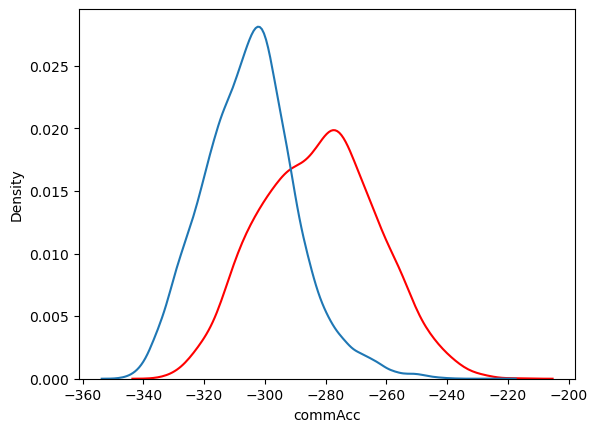

In [41]:
sns.kdeplot(reshuffled_data.commAcc[reshuffled_data.conservative], color='red')
sns.kdeplot(reshuffled_data.commAcc[np.logical_not(reshuffled_data.conservative)])

## Plot baseline vs evolved frequency of conservativity 

In [42]:
baseline = reshuffled_data[reshuffled_data.gen==0].conservative.mean()
evolved = reshuffled_data.conservative.mean()
print('baseline: ', baseline)
print('evolved:  ', evolved)
print(evolved/baseline)

baseline:  0.04
evolved:   0.2030467163168585
5.076167907921462


## Plot evolution of conservativity

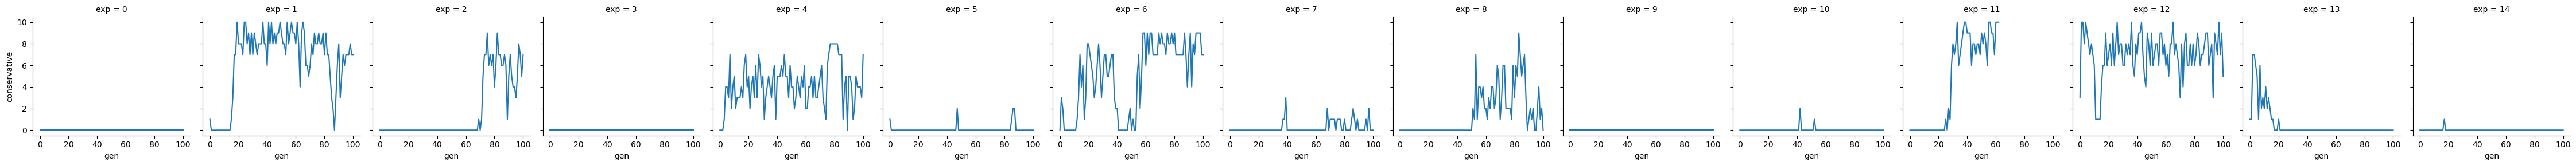

In [43]:
g = sns.FacetGrid(
    reshuffled_data.groupby(['gen','exp']).conservative.sum().reset_index(),
    col='exp'
)

g.map_dataframe(
    sns.lineplot,
    x='gen',
    y='conservative'
)

<Axes: xlabel='gen', ylabel='conservative'>

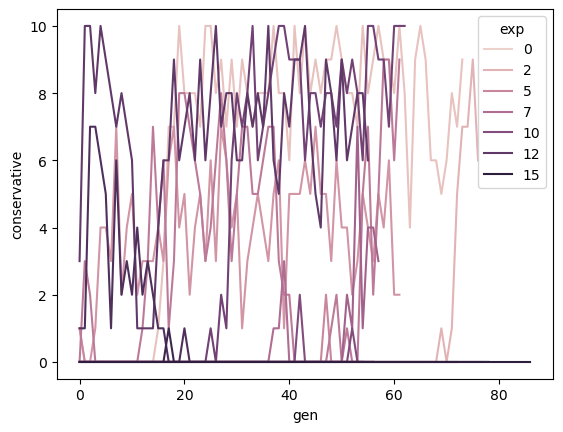

In [15]:
sns.lineplot(
    reshuffled_data.groupby(['gen','exp']).conservative.sum().reset_index(),
    x='gen',
    y='conservative',
    hue='exp'
)
# plt.plot(reshuffled_data.groupby('gen').size())

In [44]:
reshuffled_data.groupby(['gen']).conservative.size()

gen
0      150
1      150
2      150
3      150
4      150
      ... 
96     140
97     140
98     140
99     140
100    140
Name: conservative, Length: 101, dtype: int64

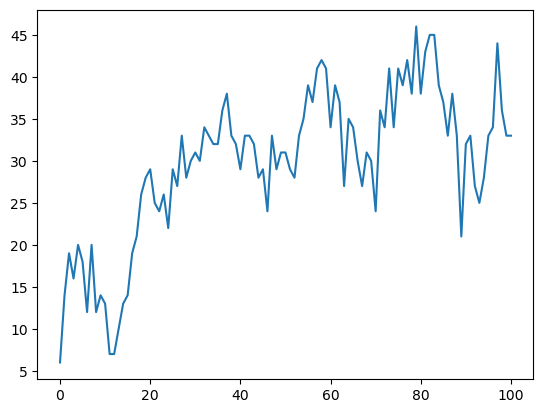

In [45]:
plt.plot(reshuffled_data.groupby(['gen']).conservative.sum())

In [46]:
def calculate_unique(x):
    y, counts = np.unique(x.comp,return_counts=True)
    pprint(list(zip(counts[np.argsort(counts)],y[np.argsort(counts)])))
    return y

reshuffled_data.groupby(['gen']).apply(calculate_unique)

[(1, 'λx.( ( X.Q ( intersection X.L X.L ) ) ( setminus X.R X.R ) ) '),
 (1, 'λx.( intGt ( cardinality ( nTh 1 X.c X.R ) X.c ) ( + 0 0 ) ) '),
 (1,
  'λx.( intGt ( - 1 ( - 0 ( cardinality ( setminus X.L X.L ) X.c ) ) ) ( '
  'cardinality X.L X.c ) ) '),
 (1, 'λx.( intGt ( + 0 1 ) 0 ) '),
 (1, 'λx.( intEq 1 ( - ( cardinality X.L X.c ) 0 ) ) '),
 (1, 'λx.( intEq ( cardinality X.R X.c ) 1 ) '),
 (1, 'λx.( intEq ( cardinality X.R X.c ) ( cardinality X.R X.c ) ) '),
 (1, 'λx.( intEq ( cardinality X.L X.c ) 1 ) '),
 (1,
  'λx.( intEq ( cardinality ( nTh 1 X.c X.L ) X.c ) ( + ( cardinality X.L X.c '
  ') 1 ) ) '),
 (1,
  'λx.( intEq ( cardinality ( nTh ( cardinality X.R X.c ) X.c X.R ) X.c ) ( '
  'cardinality X.R X.c ) ) '),
 (1, 'λx.( intEq ( - 1 1 ) 0 ) '),
 (1,
  'λx.( or ( intEq 0 ( cardinality X.R X.c ) ) ( intEq ( + 0 1 ) ( cardinality '
  'X.R X.c ) ) ) '),
 (1, 'λx.( intEq ( - 0 0 ) 0 ) '),
 (1, 'λx.( intEq ( - ( cardinality X.L X.c ) ( cardinality X.R X.c ) ) 0 ) '),
 (1, 'λx.( intEq

gen
0      [λx.( ( X.Q ( intersection X.L X.L ) ) ( setmi...
1      [λx.( ( X.Q ( nTh ( - ( cardinality ( intersec...
2      [λx.( ( X.Q ( intersection X.R X.L ) ) X.L ) ,...
3      [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
4      [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
                             ...                        
96     [λx.( ( X.Q ( intersection X.L X.R ) ) ( union...
97     [λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) ,...
98     [λx.( ( X.Q ( intersection ( intersection X.L ...
99     [λx.( ( X.Q ( intersection X.L X.R ) ) X.R ) ,...
100    [λx.( ( X.Q ( setminus ( setminus X.L X.R ) X....
Length: 101, dtype: object

## Explore individual generations

In [56]:
df_plot = reshuffled_data[reshuffled_data['exp']==12]

(-2.0, 101.0)

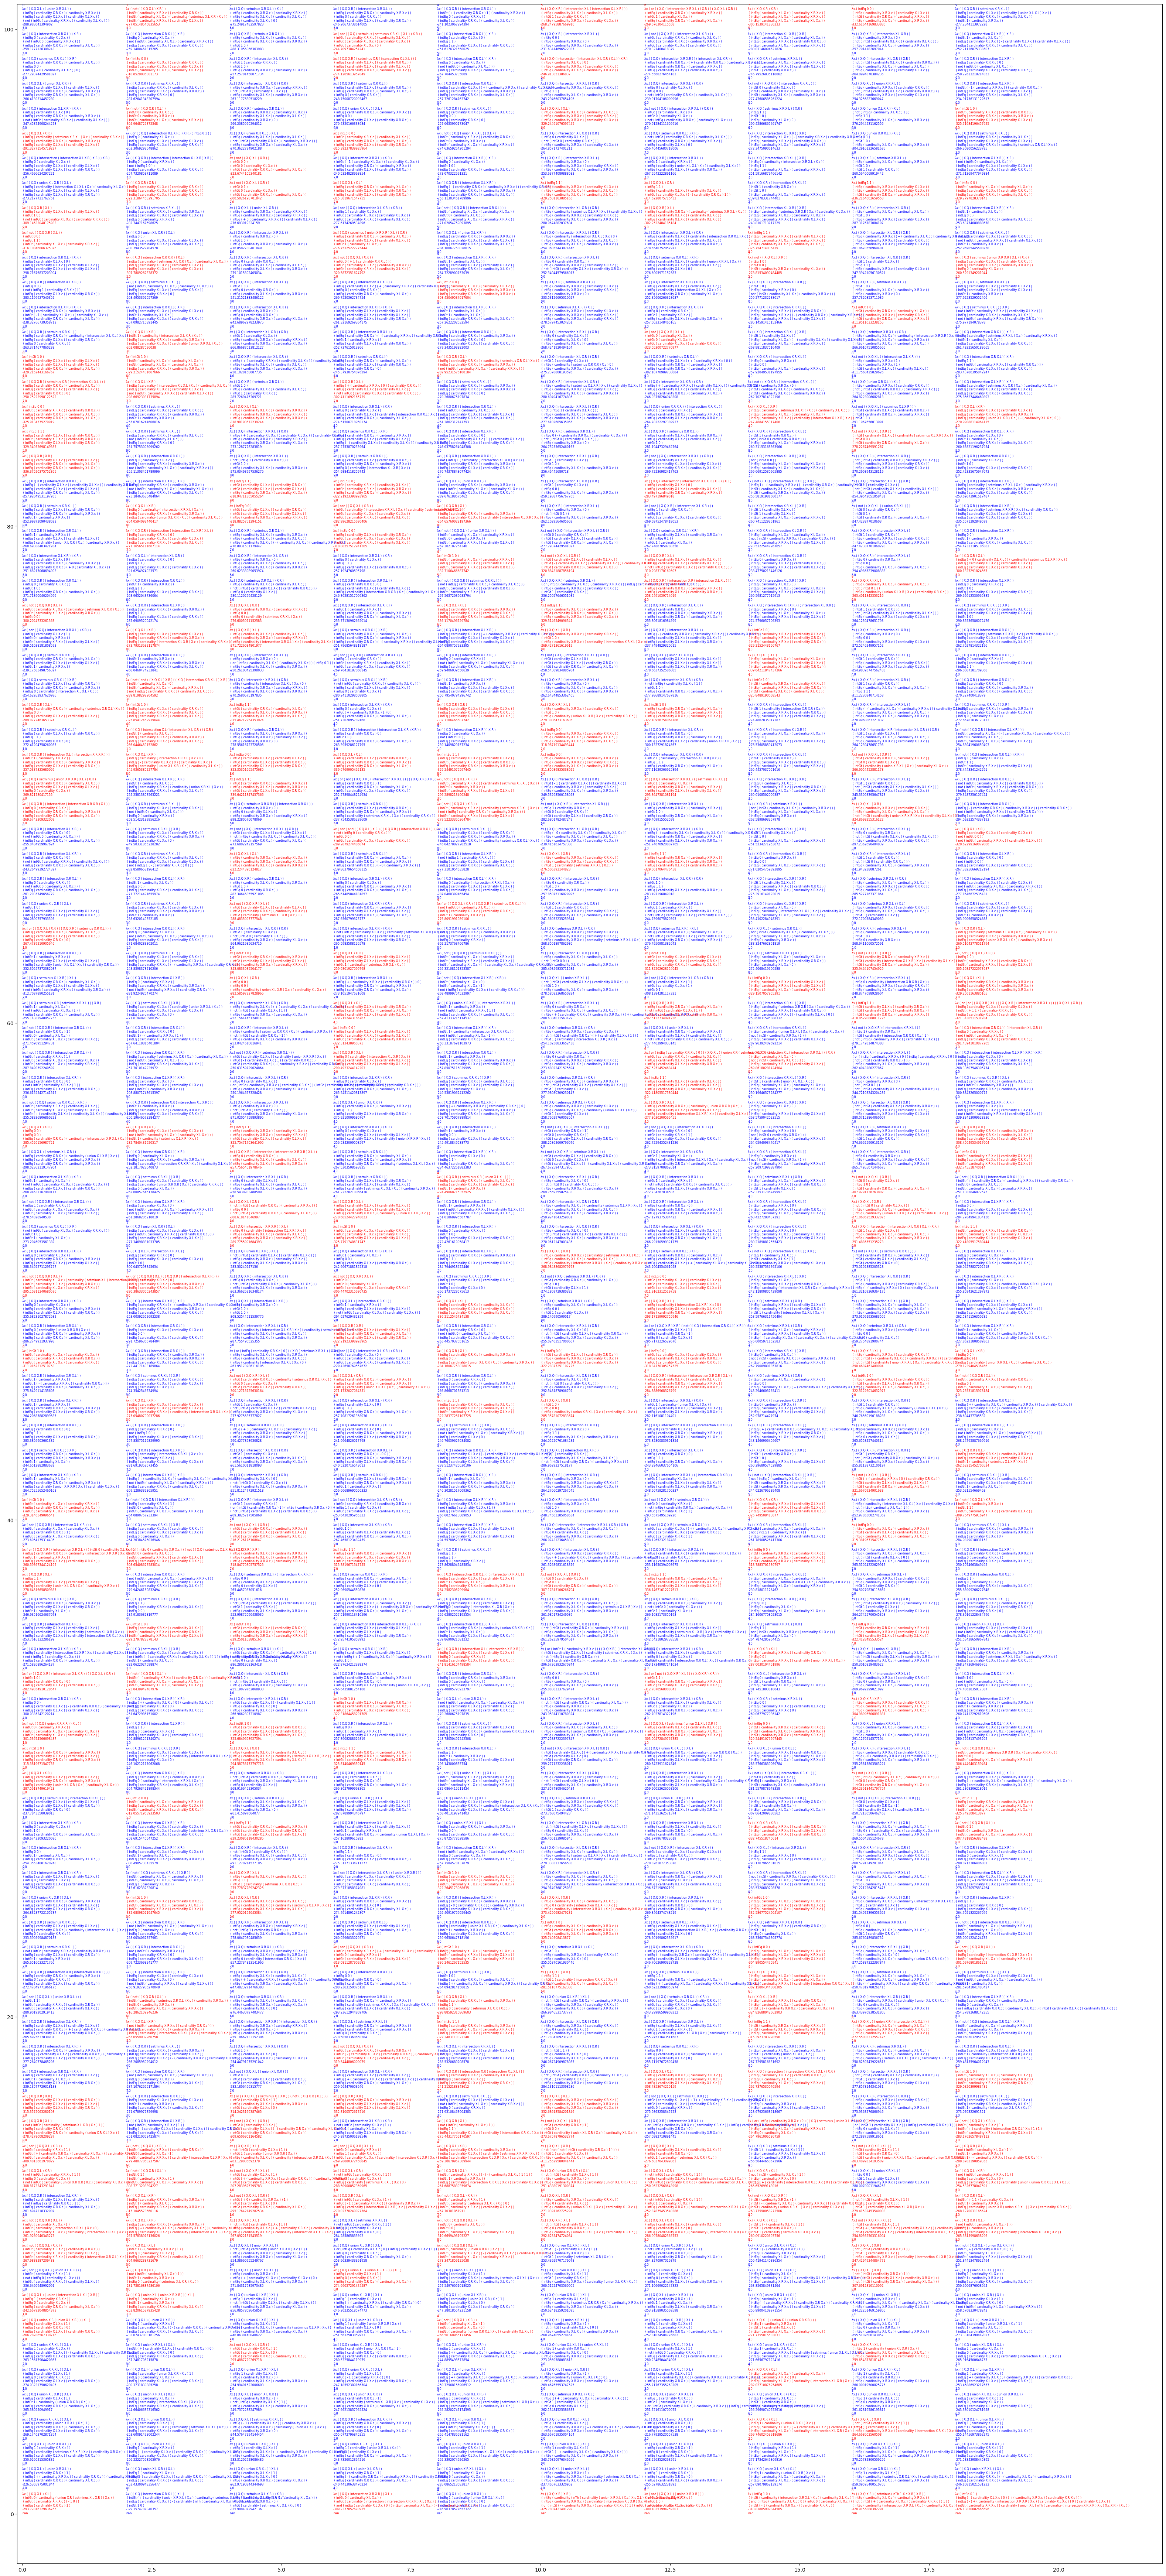

In [58]:
fig,ax = plt.subplots(figsize=(40,90))
for i, agent in df_plot.iterrows():
    color = 'blue' if agent.conservative else 'red'
    text = (
        str(agent.child)
        + '\n'
        + agent.comp
        +'\n'
        +str(agent.Q1)
        + '\n'
        +str(agent.Q2)
        + '\n'
        +str(agent.Q3)
        + '\n'
        +str(agent.commAcc)
        +'\n'+str(agent.parent)
    )
    ax.text(
        agent.child*2, 
        agent.gen, 
        text,
        color=color,
        fontsize='xx-small'
    )
ax.set_xlim(-0.1,22)
ax.set_ylim(-2,df_plot.gen.max()+1)

In [58]:
pprint(data[4]['generation'][3]['children'][4]['hypothesis'].split('|'))

['λx.( ( X.Q ( intersection X.L X.R ) ) X.R ) ',
 ' ( intGt 1 ( cardinality X.L X.c ) ) ',
 ' ( intEq ( cardinality X.L X.c ) ( cardinality X.L X.c ) ) ',
 ' ( intEq ( cardinality X.R X.c ) 1 )']


In [56]:
data[4]['generation'][4]['children'][1]['learningData']

['[DATA: { (-4, 0), (1, 1), (7, 1), (8, 0), (10, 0),  } -> ( ( Q1 target ) even ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-9, 0), (0, 0), (5, 1), (9, 0), (10, 1),  } -> ( something 0 ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-8, 0), (2, 0), (4, 0), (6, 1), (8, 1),  } -> ( ( Q1 target ) prime ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-10, 1), (-7, 0), (-6, 1), (-4, 1), (-1, 0),  } -> ( ( Q1 even ) distractor ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-5, 1), (1, 0), (2, 0), (3, 0), (8, 0),  } -> ( ( Q3 0 ) target ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-6, 0), (-2, 0), (1, 1), (3, 1), (9, 0),  } -> ( l_not ( ( Q3 distractor ) 5 ) ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-9, 0), (-8, 1), (-7, 0), (1, 0), (5, 0),  } -> ( ( Q3 prime ) target ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-8, 1), (-5, 0), (1, 0), (4, 0), (7, 1),  } -> ( ( Q3 9 ) 1 ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-10, 1), (-9, 0), (4, 1), (5, 0), 

# Only learning

In [25]:
only_learning_data = get_data('../../data/only_learning/')

In [31]:
print('proportion conservative: ', only_learning_data.conservative.mean())

proportion conservative:  0.0060643564356435645


In [32]:
only_learning_data

exp  gen  child                                                hyp  \
0        0    0      0  λx.( ( X.Q X.R ) X.L ) | ( intEq 1 ( + ( cardi...   
1        0    0      1  λx.( ( X.Q ( union X.R X.L ) ) X.R ) | ( intEq...   
2        0    0      2  λx.( ( X.Q ( union X.R X.R ) ) X.L ) | ( intGt...   
3        0    0      3  λx.( intGt ( cardinality X.R X.c ) 0 ) | ( int...   
4        0    0      4  λx.( intGt ( + 1 ( cardinality X.R X.c ) ) 0 )...   
...    ...  ...    ...                                                ...   
16155   15  100      5  λx.( intGt 1 0 ) | ( intGt ( cardinality X.L X...   
16156   15  100      6  λx.( intEq 0 0 ) | ( intGt ( cardinality X.L X...   
16157   15  100      7  λx.( ( X.Q X.R ) X.R ) | ( intEq ( cardinality...   
16158   15  100      8  λx.( ( X.Q X.L ) X.R ) | ( intEq ( cardinality...   
16159   15  100      9  λx.( intEq 0 0 ) | ( intGt ( cardinality X.L X...   

          commAcc  parent original  \
0     -327.175131     NaN     None   
1     -321.552300     NaN     None   
2     -326.357670     NaN     None   
3     -322.320212     NaN     None   
4     -311.727821     NaN     None   
...           ...     ...      ...   
16155 -325.630843     3.0     None   
16156 -336.280999     9.0     None   
16157 -329.150706     4.0     None   
16158 -308.520239     4.0     None   
16159 -329.215244     1.0     None   

                                                  comp  \
0                              λx.( ( X.Q X.R ) X.L )    
1                λx.( ( X.Q ( union X.R X.L ) ) X.R )    
2                λx.( ( X.Q ( union X.R X.R ) ) X.L )    
3              λx.( intGt ( cardinality X.R X.c ) 0 )    
4      λx.( intGt ( + 1 ( cardinality X.R X.c ) ) 0 )    
...                                                ...   
16155                                λx.( intGt 1 0 )    
16156                                λx.( intEq 0 0 )    
16157                          λx.( ( X.Q X.R ) X.R )    
16158                          λx.( ( X.Q X.L ) X.R )    
16159                                λx.( intEq 0 0 )    

                                                      Q1  \
0       ( intEq 1 ( + ( cardinality X.L X.c ) ( cardi...   
1                                         ( intEq 1 1 )    
2       ( intGt ( cardinality X.R X.c ) ( cardinality...   
3                   ( intEq ( cardinality X.L X.c ) 0 )    
4       ( intGt ( cardinality X.L X.c ) ( + ( + 1 ( c...   
...                                                  ...   
16155   ( intGt ( cardinality X.L X.c ) ( cardinality...   
16156   ( intGt ( cardinality X.L X.c ) ( cardinality...   
16157   ( intEq ( cardinality X.L X.c ) ( cardinality...   
16158   ( intEq ( cardinality X.R X.c ) ( cardinality...   
16159   ( intGt ( cardinality X.L X.c ) ( cardinality...   

                                                      Q2  \
0       ( not ( intEq ( cardinality X.R X.c ) ( + ( +...   
1       ( intGt ( cardinality ( setminus X.R X.R ) X....   
2       ( intGt ( cardinality X.R X.c ) ( - 1 ( cardi...   
3       ( intEq ( cardinality X.L X.c ) ( cardinality...   
4       ( intEq ( cardinality X.L X.c ) ( cardinality...   
...                                                  ...   
16155               ( intEq 1 ( cardinality X.L X.c ) )    
16156   ( intEq ( cardinality X.L X.c ) ( cardinality...   
16157                                     ( intEq 1 1 )    
16158   ( intEq ( cardinality X.L X.c ) ( cardinality...   
16159   ( intEq ( cardinality X.R X.c ) ( cardinality...   

                                                      Q3  conservative  
0       ( or ( intGt ( cardinality X.L X.c ) ( cardin...         False  
1       ( intEq ( - ( - ( cardinality X.L X.c ) ( + (...          True  
2                    ( intEq ( cardinality X.R X.c ) 0 )         False  
3       ( intEq ( cardinality X.R X.c ) ( cardinality...         False  
4       ( intEq ( - ( + 1 1 ) ( cardinality X.L X.c )...         False  
...                                             